In [ ]:
# to center outputs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
HTML("""
<script>
  (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){
  (i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),
  m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)
  })(window,document,'script','https://www.google-analytics.com/analytics.js','ga');

  ga('create', 'UA-83860748-1', 'auto');
  ga('send', 'pageview');

</script>
""")

Least Squares Curve Fitting
====

The goal of this exercise will be to predict the value $ t $ of one or more target variables $ x $ given a training data set comprising $N$ observations  
$\textbf{x} = (x_1, ..., x_M)^T$ where $ n = 1,...,N$  
together with their corresponding target values $\textbf{t} = (t_1, ..., t_M)^T$ for each observation (note that $\textbf{x}$ and $\textbf{t}$ are column vectors).

the goal is to predict the value of $t$ for a new value of $x$

Obviously this values has been generated from an unknown function $f(x)$.  
The points on this exercise are generated from the function below, with some gaussian noise added.$$f(x) = sin(2\pi x)$$ 

In the code below we have generated the training points $(x_n, t_n)$ (in blue) and plotted them. For reference the function $f(x)$ is shown in green.


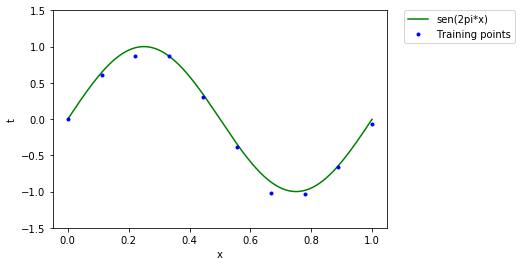

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib import cm


np.random.seed(9) # We want the same random points every time we run the program that's why we use a seed
x_axis = np.arange(0, 1, 0.0005) # The x axes to plot graphs
N = 10  # Number of training points
'''
This is the function from which the data is generated, in a real life example this would be unknown
and our objective would be to guess a function as close as possible
'''
def f(x):
    return np.sin(2*np.pi * x)

# Generate N training points and their values
training_x = np.linspace(0, 1, num=N)
# We add some noise to the points
noise = np.random.normal(0, 0.1, len(training_x))
training_t = np.array([f(x[0])+x[1] for x in zip(training_x, noise)])
# now we have N points each one with their x and t component

#Let's draw some graphs!
def draw_f_func():
    return plt.plot(x_axis, [f(i) for i in x_axis], 'g-', label='sen(2pi*x)')


def draw_training_points():
    return plt.plot(training_x, training_t, 'b.', label='Training points')


plt.close("all")
fig = plt.figure()
plt.xlabel('x')
plt.ylabel('t')

sin_plot, = draw_f_func()
training_plot, = draw_training_points()

plt.ylim(-1.5, 1.5)
plt.legend(handles=[sin_plot, training_plot])
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
# Place a legend to the right of the plot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Our primary belief about the function $f$ is that it has the form  

$$ y(\boldsymbol{\phi}, \textbf{w}) = w_0 + w_1\phi_1 + w_2\phi_2 + ... + w_M\phi_M$$

both $\boldsymbol{\phi}$ and $\textbf{w}$ are denoted in bold because those are vector variables where  
$\boldsymbol{\phi} = (\phi_1, ..., \phi_M)^T $  
$\textbf{w} = (w_1, ..., w_M)^T $

The function $y()$ is called "the model" and and choosing the right one is where generally the difficult task is.

we should note that our $y()$ is a linear function of the parameters $\textbf{w}$ and $\boldsymbol{\phi}$ and this imposes significant limitations on the model i.e: We can only draw lines with that $y()$.

To give our model more flexibility we are going to change it a bit

$$ y(\textbf{x}, \textbf{w}) = w_0 + \sum_{j=1}^{M-1} w_j\phi_j(\textbf{x}) $$

Instead of using a fixed vector $\boldsymbol{\phi}$ we have converted it to functions of $x$ (where $\textbf{x} = (x_1, ..., x_M)^T $). $\phi_j(\textbf{x})$ are known as *basis functions*. The basis functions are the ones that we should choose and that rule the model while the vector $\textbf{w}$ is the vector of parameters (weights if you want) that we should learn.  
If we denote the maximum value of the index $j$ by $M-1$ the total number of parameters in this model will be $M$.

The parameter $w_0$ allows for any fixed offset in the data and is sometimes called a *bias* parameter. it is often convenient to define an additional dummy *basis function* $\phi_0(\textbf{x}) = 1$ so that

$$ y(\textbf{x}, \textbf{w}) = \sum_{j=0}^{M-1} w_j\phi_j(\textbf{x}) = \textbf{w}^T\boldsymbol{\phi}(\textbf{x}) $$
Writing it with its matrix sizes
$$ \underset{1\times M}{\textbf{w}^T} \times \underset{M\times 1}{\boldsymbol{\phi}(\textbf{x})} = \underset{1 \times 1}{y(\textbf{x}, \textbf{w})}$$

There are many different choices for the basis functions, for our exercise I have chosen 
$ \boldsymbol{\phi}(\textbf{x}) = \{x_1^1, x_2^2,.., x_j^j\} $ or in a more formal way $\phi_j(\textbf{x}) = x_j^j $ (remember that $\phi_0(\textbf{x}) = 1$ and that $\textbf{x}$ is a vector of size M)

if we plot our *basis functions* for $ j = \{1, 2,..., 4\} $ as a function of $ x $ it will look something like this

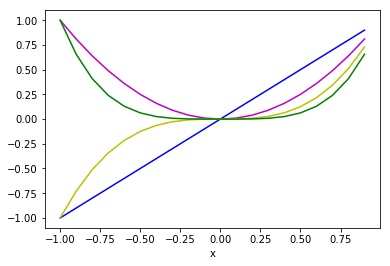

In [3]:
# this is our choosen basis function (fi sub j), note that fi sub 0 is always 1
@np.vectorize
def basis_function_ele(x, j):
    if(j == 0):
        return 1.0
    return x ** j


# single dim vector, this is a single row of the FI matrix
def basis_function_vector(x):
    return basis_function_ele(x, np.arange(0, M))


def basis_function_matrix(vector_x):
    return np.array([basis_function_vector(i) for i in vector_x])


# we draw 5 of our basis functions
plt.close("all")
plt.xlabel('x')
basis_x = np.arange(-1, 1, 0.1)
colors = ['b-', 'm-', 'y-', 'g-', 'c-']
for j in np.arange(1, 5):
    plt.plot(basis_x, basis_function_ele(basis_x, j), colors[j-1])
plt.show()

We can also write our basis functions in a $ N \times M $ matrix called the *design matrix* and denoted by 
$$ \Phi = 
\begin{bmatrix}
    \phi_0(x_1)  & \phi_1(x_1) & \dots  & \phi_{M-1}(x_1) \\
    \phi_0(x_2)  & \phi_1(x_2) & \dots  & \phi_{M-1}(x_2) \\
    \vdots       & \vdots      & \ddots & \vdots \\
    \phi_0(x_N)  & \phi_1(x_N) & \dots  & \phi_{M-1}(x_N)
\end{bmatrix}
$$
This will allow us to write our Python code in vectorial form instead of using loops making our code more efficient

To explain our *basis functions* in a easy way you could see it as if we have at our disposition any polynomial curve of any degree (up to $M$) and with the parameter vector $\textbf{w}$ we can give more weights to certain degrees of that polynomial to make it the closer we can to $f(x) = sin(2\pi x)$.

Now we have the task of "learning" the correct $w$ vector, for that we should define a new function $E(\textbf{w})$ that gives us an idea or a "*rating*" on how good our selected $\textbf{w}$ is.

The simplest one can be the [sum-of-squares error function](https://en.wikipedia.org/wiki/Mean_squared_error "Mean squared error")

given by 
$$ 
E(\textbf{w}) = 
\frac{1}{2}\sum_{n=1}^{N} \{t_n -  y(\textbf{x},\textbf{w}) \}^2 
= \frac{1}{2}\sum_{n=1}^{N} \{t_n -  \textbf{w}^T \boldsymbol{\phi}(x_n)\}^2$$

That is: "for each value of each training point $t_n$ (with a total of $N$ training points) we subtract our prediction $y(\textbf{x},\textbf{w})$ and we sum those errors so we get a number that says how good or how bad (the lower the number the better) our prediction was".

The code below plots the function $E(\textbf{w}) $ for $ M =2 $



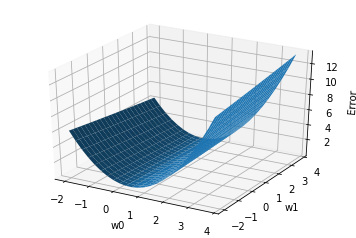

In [8]:
# Draw Error function for M = 2
'''
This function is equivalent to basis_function_vector 
except that in this one we accept M as argument just to draw it as M = 2
'''
def basis_function_vector_aux(x, M):
    return np.array([basis_function_ele(x, i) for i in np.arange(0, M)])

# Error function to plot
def drawable_e_func(w, M):
    summatory = np.sum([(training_t[i] - w @ basis_function_vector_aux(training_x[i], M))**2 
                        for i in np.arange(0,M)])
    return 0.5 * summatory

plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = Y = np.arange(-2, 4, 0.25)
X, Y = np.meshgrid(X, Y)
zs = np.array([drawable_e_func(np.array([x, y]), 2)
              for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z) #cmap=cm.jet

ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.set_zlabel('Error')
plt.show()

The idea is that if we minimize the error function $E(\textbf{w}) $ we will get the best parameters $\textbf{w} $ to fit our model $ y(\textbf{x}, \textbf{w}) $ with the curve $ f(x) $. For that we can calculate the [gradient](https://en.wikipedia.org/wiki/Gradient "Gradient") and solve the equation. That would be the mathematical way (which I will also explain briefly) but as an engineer I prefer to use different methods plus sometimes you cannot solve the gradient equation.

The method we are going to use is called  [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent "Gradient descent") and as the image shows it consist on taking small steps in the opposite direction of the gradient vector $ \nabla E(\textbf{w}) $

<img src="images/512px-Gradient_descent.svg.png",width=350,height=360>

Each step get us closer to the minimun i.e our solution for $ \textbf{w} $.


We can modify the error function a bit, adding a regularization coefficient $ \lambda $ in order to discourage the coefficients $\textbf{w}$ from reaching large values. Then the final error function becomes $$ E(\textbf{w}) = \frac{1}{2}\sum_{n=1}^{N} \{t_n -  \textbf{w}^T \boldsymbol{\phi}(x_n)\}^2 + \frac{\lambda}{2}\textbf{w}^T\textbf{w} $$
This particular choice of regularizer is known as *weight decay* because it encourages weight values to decay towards zero.

In our exercise we will choose $\lambda = -0.3$ and $ M = 4 $

In [ ]:
M = 4  # we set the complexity of the model (aka degree of the polynomial)
lambda_val = -0.3

def error_theano(w, fi_matrix):
    return 0.5 * T.sum(((training_t - T.dot(fi_matrix, w))**2))
    + (lambda_val / 2) * T.dot(w, w)

# vars ending in _th are theano variables
w_th = T.vector('w_th')
fi_matrix_th = T.matrix('fi_matrix_th')
training_x_th = T.vector('training_x_th')
training_t_th = T.vector('training_t_th')

# ERROR FUNCTION
E = theano.function(
    inputs=[w_th, fi_matrix_th],
    outputs=error_theano(w_th, fi_matrix_th)
)

In [ ]:
# Calcular gradiente del error
E_grad_th = theano.gradient.jacobian(error_theano(w_th, fi_matrix_th).flatten(), w_th)
E_grad = theano.function([w_th, fi_matrix_th], E_grad_th)

fi_matrix = basis_function_matrix(training_x)
array_test = np.linspace(0,M,num=M)

assert E_grad(array_test, fi_matrix).flatten().shape[0] == M, "El gradiente debe ser de tamano: {0}".format(M)
print("FIN")

In [ ]:
# Descenso de gradiente

w = np.linspace(0, M, num=M)

print("W inicial: \n{0}\n".format(w))
print("Error inicial: \n{0}\n".format(E(w, fi_matrix)))

def calculate_gradient(w, fi_matrix):
    return E_grad(w, fi_matrix)

max_iterations = 100000
learning_rate = np.full(M ,0.01, dtype=float) #one learning rate by each parameter W
gradient = np.zeros(M)
gradient_old = np.zeros(M)

for i in np.arange(0,max_iterations):
    gradient = calculate_gradient(w, fi_matrix).flatten()    
    for j in np.arange(0, M):
        if((gradient[j] > 0) == (gradient_old[j] >0)):
            learning_rate[j] = learning_rate[j] * 1.01
        else:
            learning_rate[j] = learning_rate[j] * 0.5   
    gradient_old = gradient.copy()    
    w = w - gradient * learning_rate
    if(np.sum(gradient**2) < 1e-7): #if the error is that small, end the descent
        break;

# import pdb; pdb.set_trace()

print("W Final: \n{0}\n".format(w))
print("Error Final: \n{0}\n".format(E(w, fi_matrix)))


def y_model(x, w):
    return w @ basis_function_vector(x)

plt.close("all")
fig = plt.figure()


ajusted_curve, = plt.plot(x_axis, [y_model(i, w) for i in x_axis], 'r-', label='Ajusted curve with lambda={0}'.format(lambda_val))
seno_plot, = draw_f_func()
training_plot, = draw_training_points()

plt.xlabel('x')
plt.ylabel('t')
plt.ylim(-1.5, 1.5)
plt.legend(handles=[seno_plot, training_plot, ajusted_curve])
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
# Tests
import unittest

class TestRegression (unittest.TestCase):
    def test_gradient (self):
        little_constant = 1e-3        
        w = np.random.uniform(low=10, high=100, size=(M))
        w_aux = np.zeros(M)
        w_aux[0] = little_constant
        w_aux += w
        theano_gradient = calculate_gradient(w, fi_matrix).flatten()
        numerical_differentiation = (E(w_aux, fi_matrix) - E(w, fi_matrix)) / little_constant        
        self.assertTrue(np.allclose([theano_gradient[0]],[numerical_differentiation]))

a = TestRegression()
suite = unittest.TestLoader().loadTestsFromModule(a)
unittest.TextTestRunner().run(suite)